In [4]:
import numpy as np

import pyccl as ccl

import pyhmcode
import pyhmcode.halo_profile_utils

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

Set up the cosmology and linear power spectrum.

In [3]:
h = 0.7
ccl_cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=h, A_s=2.1e-9, n_s=0.97)

pofk_k = np.logspace(-4, 1.5, 100)
pofk_a = np.linspace(1/(1+6), 1, 10)
pofk_z = 1/pofk_a - 1

pofk_lin = np.array([ccl.linear_matter_power(ccl_cosmo, k=pofk_k, a=a_) for a_ in pofk_a])

pofk_k_h = pofk_k/h
pofk_lin_h3 = pofk_lin*h**3


Set up the halo profiles.

In [ ]:
hmcode_cosmo = pyhmcode.halo_profile_utils.ccl2hmcode_cosmo(
                        ccl_cosmo=ccl_cosmo,
                        pofk_lin_k_h=pofk_k_h, pofk_lin_z=pofk_z[::-1],
                        pofk_lin=pofk_lin_h3[::-1],
                        log10_T_heat=7.8)

a_profiles = np.linspace(1/(1+6), 1.0, 12)
k_h_profiles = np.logspace(-5, 2, 100)

# Halo profiles
profile_generator = pyhmcode.halo_profile_utils.HMxProfileGenerator(
                        hmcode_cosmo,
                        a_arr=a_profiles, k_arr=k_h_profiles,
                        fields=[pyhmcode.field_matter,
                                pyhmcode.field_cdm,
                                pyhmcode.field_electron_pressure],
                        add_diffuse=False)

# Diffuse halo profiles (only used for 2h terms)
profile_diffuse_generator = pyhmcode.halo_profile_utils.HMxProfileGenerator(
                        hmcode_cosmo,
                        a_arr=a_profiles, k_arr=k_h_profiles,
                        fields=[pyhmcode.field_matter,
                                pyhmcode.field_cdm,
                                pyhmcode.field_electron_pressure],
                        add_diffuse=True)

Compute the power spectra with HMCode

In [ ]:
hmcode_Pk = {}

hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=True)
hmcode_Pk["matter"] = pyhmcode.calculate_nonlinear_power_spectrum(
                                            hmcode_cosmo, hmod, 
                                            fields=[pyhmcode.field_matter,
                                                    pyhmcode.field_electron_pressure],
                                            verbose=True)

hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=True)
hmod.response_baseline = 0
hmcode_Pk["matter_no_response"] = pyhmcode.calculate_nonlinear_power_spectrum(
                                            hmcode_cosmo, hmod, 
                                            fields=[pyhmcode.field_matter,
                                                    pyhmcode.field_electron_pressure],
                                            verbose=True)

hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=True)
hmod.response_baseline = 0
hmod.twhim_array = hmod.twhim_array * 1e-4
hmcode_Pk["matter_no_response_no_twhim"] = pyhmcode.calculate_nonlinear_power_spectrum(
                                            hmcode_cosmo, hmod, 
                                            fields=[pyhmcode.field_matter,
                                                    pyhmcode.field_electron_pressure],
                                            verbose=True)

hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=True)
hmod.response_baseline = 0
hmod.twhim_array = hmod.twhim_array * 1e-4
hmod.m0_array = hmod.m0_array * 1e-4
hmcode_Pk["matter_no_response_no_diffuse"] = pyhmcode.calculate_nonlinear_power_spectrum(
                                            hmcode_cosmo, hmod, 
                                            fields=[pyhmcode.field_matter,
                                                    pyhmcode.field_electron_pressure],
                                            verbose=True)

hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=True)
hmcode_Pk["cdm"] = pyhmcode.calculate_nonlinear_power_spectrum(
                                            hmcode_cosmo, hmod, 
                                            fields=[pyhmcode.field_cdm,
                                                    pyhmcode.field_electron_pressure],
                                            verbose=True)

hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=True)
hmod.response_baseline = 0
hmcode_Pk["cdm_no_response"] = pyhmcode.calculate_nonlinear_power_spectrum(
                                            hmcode_cosmo, hmod, 
                                            fields=[pyhmcode.field_cdm,
                                                    pyhmcode.field_electron_pressure],
                                            verbose=True)

hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=True)
hmod.twhim_array = hmod.twhim_array * 1e-3
hmod.response_baseline = 0
hmcode_Pk["cdm_no_response_no_twhim"] = pyhmcode.calculate_nonlinear_power_spectrum(
                                            hmcode_cosmo, hmod, 
                                            fields=[pyhmcode.field_cdm,
                                                    pyhmcode.field_electron_pressure],
                                            verbose=True)


Compute the halo model power spectra with CCL.

In [6]:

mass_def = ccl.halos.MassDef("vir", 'matter')
hmf = ccl.halos.MassFuncSheth99(ccl_cosmo, mass_def=mass_def, mass_def_strict=False, use_delta_c_fit=True)
hbf = ccl.halos.HaloBiasSheth99(ccl_cosmo, mass_def=mass_def, mass_def_strict=False, use_delta_c_fit=True)
hmc = ccl.halos.HMCalculator(ccl_cosmo, hmf, hbf, mass_def)


a = np.linspace(1/(1+6), 1.0, 12)
k = np.logspace(-4, 1.5, 100)

ccl_Pk = {}
# Power spectrum
ccl_Pk["cdm_cdm"] = ccl.halos.halomod_Pk2D(
                            cosmo=ccl_cosmo, hmc=hmc, 
                            prof=profile_generator.cdm_profile,
                            normprof1=False,
                            a_arr=a, lk_arr=np.log(k),
                            )
ccl_Pk["cdm_cdm_1h"] = ccl.halos.halomod_Pk2D(
                            cosmo=ccl_cosmo, hmc=hmc, 
                            prof=profile_generator.cdm_profile,
                            normprof1=False,
                            a_arr=a, lk_arr=np.log(k),
                            get_2h=False
                            )
ccl_Pk["cdm_cdm_2h_diffuse"] = ccl.halos.halomod_Pk2D(
                            cosmo=ccl_cosmo, hmc=hmc, 
                            prof=profile_diffuse_generator.cdm_profile,
                            normprof1=False,
                            a_arr=a, lk_arr=np.log(k),
                            get_1h=False
                            )

ccl_Pk["matter_matter"] = ccl.halos.halomod_Pk2D(
                            cosmo=ccl_cosmo, hmc=hmc, 
                            prof=profile_generator.matter_profile,
                            normprof1=False,
                            a_arr=a, lk_arr=np.log(k),
                            )
ccl_Pk["matter_matter_1h"] = ccl.halos.halomod_Pk2D(
                            cosmo=ccl_cosmo, hmc=hmc, 
                            prof=profile_generator.matter_profile,
                            normprof1=False,
                            a_arr=a, lk_arr=np.log(k),
                            get_2h=False
                            )
ccl_Pk["matter_matter_2h_diffuse"] = ccl.halos.halomod_Pk2D(
                            cosmo=ccl_cosmo, hmc=hmc, 
                            prof=profile_diffuse_generator.matter_profile,
                            normprof1=False,
                            a_arr=a, lk_arr=np.log(k),
                            get_1h=False,
                            )

ccl_Pk["cdm_pressure"] = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=profile_generator.cdm_profile,
                                                prof2=profile_generator.pressure_profile,
                                                normprof1=False, normprof2=False,
                                                a_arr=a, lk_arr=np.log(k),
                                                )
ccl_Pk["cdm_pressure_1h"] = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=profile_generator.cdm_profile,
                                                prof2=profile_generator.pressure_profile,
                                                normprof1=False, normprof2=False,
                                                a_arr=a, lk_arr=np.log(k),
                                                get_2h=False
                                                )
ccl_Pk["cdm_pressure_2h_diffuse"] = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=profile_diffuse_generator.cdm_profile,
                                                prof2=profile_diffuse_generator.pressure_profile,
                                                normprof1=False, normprof2=False,
                                                a_arr=a, lk_arr=np.log(k),
                                                get_1h=False
                                                )

ccl_Pk["matter_pressure"] = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=profile_generator.matter_profile,
                                                prof2=profile_generator.pressure_profile,
                                                normprof1=False, normprof2=False,
                                                a_arr=a, lk_arr=np.log(k),
                                                )
ccl_Pk["matter_pressure_1h"] = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=profile_generator.matter_profile,
                                                prof2=profile_generator.pressure_profile,
                                                normprof1=False, normprof2=False,
                                                a_arr=a, lk_arr=np.log(k),
                                                get_2h=False,
                                                )
ccl_Pk["matter_pressure_2h_diffuse"] = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=profile_diffuse_generator.matter_profile,
                                                prof2=profile_diffuse_generator.pressure_profile,
                                                normprof1=False, normprof2=False,
                                                a_arr=a, lk_arr=np.log(k),
                                                get_1h=False
                                                )

ccl_Pk["pressure_pressure"] = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=profile_generator.pressure_profile,
                                                normprof1=False, normprof2=False,
                                                a_arr=a, lk_arr=np.log(k),
                                                )
ccl_Pk["pressure_pressure_1h"] = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=profile_generator.pressure_profile,
                                                normprof1=False, normprof2=False,
                                                a_arr=a, lk_arr=np.log(k),
                                                get_2h=False,
                                                )
ccl_Pk["pressure_pressure_2h_diffuse"] = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=profile_diffuse_generator.pressure_profile,
                                                normprof1=False, normprof2=False,
                                                a_arr=a, lk_arr=np.log(k),
                                                get_1h=False
                                                )

# To compute the HMx power spectra, add the diffuse 2h term and the "normal" 1h term
# This requires the add_pk2d branch of CCL at the moment
for probe_a, probe_b in [("cdm", "cdm"), ("cdm", "pressure"), ("pressure", "pressure"),
                         ("matter", "matter"), ("matter", "pressure")]:
    ccl_Pk[f"{probe_a}_{probe_b}_diffuse"] = ccl_Pk[f"{probe_a}_{probe_b}_1h"] + ccl_Pk[f"{probe_a}_{probe_b}_2h_diffuse"]


Plot the comparison between the HMCode and CCL halo model power spectra.

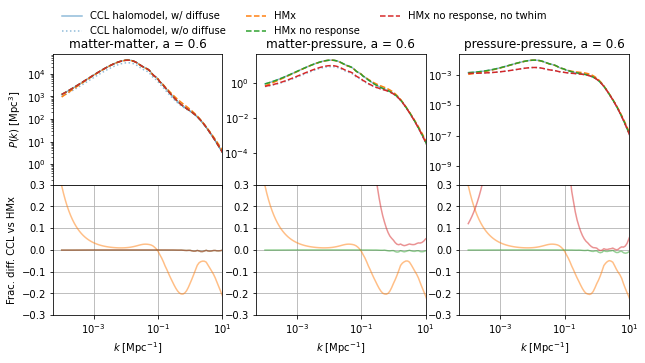

In [10]:
k = pofk_k
a_idx = -5
a = pofk_a[a_idx]

fig, ax = plt.subplots(2, 3, sharex=True, squeeze=False, figsize=(10, 5))
fig.subplots_adjust(hspace=0, left=0.1, top=0.85)

plot_kwargs = {"alpha": 0.5}

matter_probe = "matter"
# matter_probe = "cdm"

probe_map = {"matter": 0, "cdm": 0, "pressure": 1}

scaling = {"matter": 1,
           "cdm": (ccl_cosmo["Omega_m"]/ccl_cosmo["Omega_c"]),
           "pressure": a**-3}

for i, (probe_a, probe_b) in enumerate([(matter_probe, matter_probe),
                                        (matter_probe, "pressure"),
                                        ("pressure", "pressure")]):
    idx_a, idx_b = probe_map[probe_a], probe_map[probe_b]

    pk_ccl = ccl_Pk[f"{probe_a}_{probe_b}"].eval(k, a, ccl_cosmo)
    pk_diffuse_ccl = ccl_Pk[f"{probe_a}_{probe_b}_diffuse"].eval(k, a, ccl_cosmo)

    ax[0,i].set_title(f"{probe_a}-{probe_b}, a = {a:.1f}")
    ax[0,i].loglog(k, pk_diffuse_ccl, **plot_kwargs,
                label="CCL halomodel, w/ diffuse")
    ax[0,i].loglog(k, pk_ccl,
                c="C0", ls=":", **plot_kwargs,
                label="CCL halomodel, w/o diffuse")

    for j, (HMx_label, HMx_Pk) in enumerate(
                            [("HMx", hmcode_Pk[matter_probe]),
                            ("HMx no response", hmcode_Pk[f"{matter_probe}_no_response"]),
                            ("HMx no response, no twhim", hmcode_Pk[f"{matter_probe}_no_response_no_twhim"])]):
        pk = HMx_Pk[idx_a, idx_b,::-1][a_idx]*h**-3 * scaling[probe_a]*scaling[probe_b]
        ax[0,i].loglog(k, pk, c=f"C{j+1}", ls="--", label=HMx_label)
        ax[1,i].semilogx(k, pk_diffuse_ccl/pk - 1,
                         **plot_kwargs, c=f"C{j+1}", label=HMx_label)
    
    ax[1,i].set_ylim(-0.3, 0.3)
    ax[1,i].grid()
    ax[1,i].set_xlabel("$k$ [Mpc$^{-1}$]")

ax[0,0].set_ylabel("$P(k)$ [Mpc$^3$]")
ax[1,0].set_ylabel("Frac. diff. CCL vs HMx")

# ax[0,0].set_ylim(bottom=1e1)
ax[0,0].set_xlim(right=10)
ax[0,0].legend(ncol=3, frameon=False, loc="upper left", bbox_to_anchor=(0,1.4))


# fig.dpi = 300
# fig.savefig(f"plots/CCL_halomodel_vs_HMx_{matter_probe}.png")